# Neural Networks on MNIST with PyTorch 



In this notebook, we build a pipeline in PyTorch for MNIST image classification:

1. **Data pipeline**: transforms, loaders
2. **Two models**: a simple **MLP** (fully-connected baseline) and a small **CNN**  
3. **Training utilities**: reproducibility, metrics, progress bars, and logging  
4. **Evaluation**: accuracy, confusion matrix, error analysis, and visualization  
5. **Experiments**: optimizer comparison, learning-rate scheduling, regularization (Dropout / weight decay), and (optional) mixed precision  


## Table of contents

- Libraries
- Reproducibility and configuration  
- Dataset and transforms  
- DataLoaders
- Visualization helpers  
- Models: MLP baseline and a compact CNN  
- Training loop (with metrics and optional AMP)  
- Evaluation: accuracy, confusion matrix, error analysis  
- Experiments: optimizers, LR scheduling, regularization  
- Practical tips & pitfalls  
- Conclusion
- References


In [1]:
# =========================
# Libraries
# =========================

import os
import math
import time
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, List, Optional

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomAffine

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Optional: sklearn only used for a nicer confusion matrix.
try:
    from sklearn.metrics import confusion_matrix
    _HAS_SKLEARN = True
except Exception:
    _HAS_SKLEARN = False

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available())


PyTorch: 2.8.0
CUDA available: False
MPS available: True


## Reproducibility and configuration

To make experiments comparable, we fix seeds and keep hyperparameters in a single config object.


In [2]:
# =========================
# Reproducibility utilities
# =========================

def seed_everything(seed: int = 42) -> None:
    import random
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Determinism settings
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("Using device:", device)


Using device: mps


In [3]:
# =========================
# Experiment configuration
# =========================

@dataclass #hyperparameters and other settings
class Config: 
    data_root: str = "data"     # directory to store/load data
    batch_size: int = 128 
    num_workers: int = 2        # for DataLoader
    pin_memory: bool = True     # for CUDA
    lr: float = 1e-3            # learning rate
    epochs: int = 10
    weight_decay: float = 0.0   # L2 regularization (decoupled weight decay for AdamW)
    dropout: float = 0.0        # dropout probability/rate
    use_amp: bool = False       # Autimatic Mixed Precision (AMP) (CUDA only)
    val_fraction: float = 0.1   # fraction of training data to use for validation

cfg = Config()
cfg


Config(data_root='data', batch_size=128, num_workers=2, pin_memory=True, lr=0.001, epochs=10, weight_decay=0.0, dropout=0.0, use_amp=False, val_fraction=0.1)

## Dataset and transforms

We use **MNIST**, a dataset of 60K +1 0K (train + test) 28×28 grayscale images of handwritten digits (0–9).

### Why transforms?
- **ToTensor()** converts images to torch tensors with values in `[0, 1]`.
- **Normalize()** standardizes the input distribution (often improving optimization).
- **Data augmentation** can reduce overfitting by showing slightly perturbed versions of training examples, for a better model generalization.

We will use
- a *plain* transform for validation/test, and  
- an *augmented* transform for training.


In [4]:
# =========================
# Transforms: Image --> Tensor
# =========================

# Empirical MEAN and STD of MNIST pixel intensities (after scaling to [0,1])
MNIST_MEAN = (0.1307,)
MNIST_STD  = (0.3081,)

test_tfms = Compose([ # Compose([T1, T2, T3]) applies T1, then T2, then T3 to input
    ToTensor(),
    Normalize(MNIST_MEAN, MNIST_STD),
])
# Normalization reduces exploding/vanishing gradients and bias toward positive activations
# I is essential for ReLU stability, Adam/SGD convergence, and meaningful weight initialization.
# No Augmentation for test/validation: 
#   Evaluation must measure true performance, not robustness to artificial noise.

train_tfms = Compose([
    RandomRotation(degrees=10), # random rotation by ~ U(-10, 10) degrees, enforces rotational invariance
    RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)), 
     # random translation and scaling
     # enforces translational and scale invariance
     # Note: MNIST digits are already roughly centered and similarly scaled.
    ToTensor(),
    Normalize(MNIST_MEAN, MNIST_STD),
])


In [5]:
# =========================
# Load datasets and split train/val
# =========================

train_full = datasets.MNIST(root=cfg.data_root, train=True, download=True, transform=train_tfms)
test_set   = datasets.MNIST(root=cfg.data_root, train=False, download=True, transform=test_tfms)

n_total = len(train_full)
n_val = int(cfg.val_fraction * n_total)
n_train = n_total - n_val

g = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_full, [n_train, n_val], generator=g)

print(f"Train size: {len(train_set)} | Val size: {len(val_set)} | Test size: {len(test_set)}")


100%|██████████| 9.91M/9.91M [00:02<00:00, 3.34MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 422kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 756kB/s]

Train size: 54000 | Val size: 6000 | Test size: 10000


## DataLoaders 

DataLoaders handle batching, shuffling, and parallel data loading.

We also inspect one batch to confirm:
- input shape is `[B, 1, 28, 28]`
- labels are integer class IDs in `[0, 9]`


In [6]:
# =========================
# DataLoaders
# =========================

train_loader = DataLoader(
    train_set,
    batch_size=cfg.batch_size,
    # determines how many samples are processed per forward/backward pass
    # loss is averaged over these samples 
    shuffle=True,
    # This randomizes sample order every epoch.
    # If False, the correlation among Batches makes gradient estimates biased
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory and device.type == "cuda",
) # DataLoader divides dataset into batches and shuffles them

val_loader = DataLoader(
    val_set,
    batch_size=cfg.batch_size,
    shuffle=False,
    # Validation is not optimization (order does not matter)
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory and device.type == "cuda",
)

test_loader = DataLoader(
    test_set,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory and device.type == "cuda",
)

xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape, xb.dtype)
print("Batch y:", yb.shape, yb.dtype, "| classes:", yb.min().item(), "to", yb.max().item())
# Expected: 
#   Batch X: torch.Size([128, 1, 28, 28]) torch.float32
#   Batch y: torch.Size([128]) torch.int64 | classes: 0 to 9

# Meaning:  
#   128 images, 
#   1 channel (grayscale), 
#   28×28 pixels, 
#   float32 (required for NN ops)
#   one label per image, integer (0-9) class indices

Batch X: torch.Size([128, 1, 28, 28]) torch.float32
Batch y: torch.Size([128]) torch.int64 | classes: 0 to 9


## Visualization helpers

When we normalize tensors, pixel values are no longer in `[0, 1]`.
So for plotting, we **unnormalize** back to roughly the original scale.


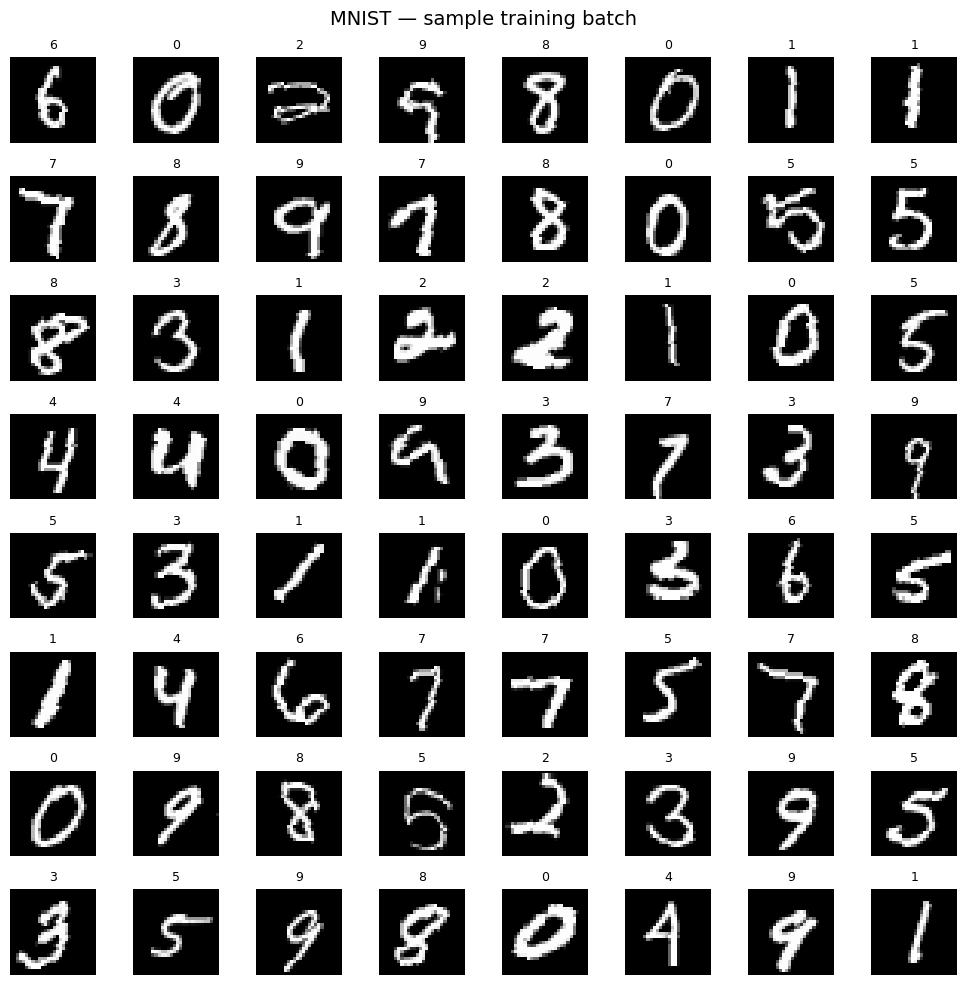

In [ ]:
# =========================
# Visualization helpers
# =========================

def unnormalize(x: torch.Tensor, mean=MNIST_MEAN, std=MNIST_STD) -> torch.Tensor:
    mean = torch.tensor(mean, device=x.device).view(1, -1, 1, 1)
    std  = torch.tensor(std, device=x.device).view(1, -1, 1, 1)
    return x * std + mean

def show_grid(images: torch.Tensor, labels: torch.Tensor, n: int = 64, title: str = "") -> None:
    images = images[:n]
    labels = labels[:n]
    images = unnormalize(images).clamp(0, 1).cpu()

    rows = int(math.sqrt(n))
    cols = int(math.ceil(n / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i >= n:
            ax.axis("off")
            continue
        ax.imshow(images[i].squeeze(0), cmap="gray")
        ax.set_title(str(labels[i].item()), fontsize=9)
        ax.axis("off")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

xb, yb = next(iter(train_loader))
show_grid(xb, yb, n=64, title="MNIST — sample training batch")

## Models

### 1) Fully Connected MLP  
Flattens the image and uses linear layers. 
Works, but it ignores spatial structure.

### 2) CNN
Exploits local patterns. 
Better for images.


In [8]:
# =========================
# Model 1: MLP baseline
# =========================

class MLP(nn.Module): # PyTorch "Machine"
        # MLP Network Architecture: 
        # Layers:   input (Bx1x28x28) 
        #           --> 1. Flatten (1x784) 
        #           --> 2. Hidden Layer 1 (ReLU + dropout) 
        #           --> 3. Hideen Layer 2 (ReLU + dropout) 
        #           --> 4. Output Layer
    def __init__(self, hidden: int = 256, dropout: float = 0.0):
        # hidden: number of neurons (width) in the (first) hidden layer(s)
        super().__init__()  # Turning on the "Machine"!
        self.net = nn.Sequential( 
            # 1. Flatten: 28x28 images to 784-dim vectors
            nn.Flatten(),                 
            # 2. Hidden Layer 1 (ReLU + dropout) 728--> 728
            nn.Linear(28 * 28, hidden),  # biases included by default (..., bias=True)  
            nn.ReLU(),
            nn.Dropout(dropout),
            # 3. Hidden Layer 2 (ReLU + dropout) 728--> 728
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            # 4. Output Layer: 728 --> 10
            nn.Linear(hidden, 10),
        )

    def forward(self, x):
        return self.net(x)


In [9]:
# =========================
# Model 2: Compact CNN
# =========================

class SmallCNN(nn.Module):
        # CNN Network Architecture:  (Two Conv blocks + Classifier Head)
        # Layers:   input (1x28x28) 
        #           --> 1. Conv --> ReLU --> Conv --> ReLU --> MaxPool (28x28 --> 14x14) 
        #           --> 1. Conv --> ReLU --> Conv --> ReLU --> MaxPool (14x14 --> 7x7) 
        #           --> 3. Flatten (1x49) --> FC --> ReLU --> FC
        #           --> 4. 10 logits
    def __init__(self, channels: int = 32, dropout: float = 0.0):
        # channels: number of filters 
        super().__init__()
        c = channels

        self.features = nn.Sequential(
            # 1.1 Conv: (input) 1x[28x28] --> c x [28x28] (+ ReLU)
            nn.Conv2d(1, c, kernel_size=3, padding=1), 
            nn.ReLU(),
            # 1.2 Conv: c x [28x28] --> c x [28x28] (+ ReLU)
            nn.Conv2d(c, c, kernel_size=3, padding=1),
            nn.ReLU(),
            # 1.3 MaxPool: c x [28x28] --> c x [14x14]
            nn.MaxPool2d(2),   

            # 2.1 Conv: c x [14x14] --> 2c x [14x14] (+ ReLU)
            nn.Conv2d(c, 2*c, kernel_size=3, padding=1),
            nn.ReLU(),
            # 2.2 Conv: 2c x [14x14] --> 2c x [14x14] (+ ReLU)
            nn.Conv2d(2*c, 2*c, kernel_size=3, padding=1),
            nn.ReLU(),
            # 2.3 MaxPool: 2c x [14x14] --> (output) 2c x [7x7]
            nn.MaxPool2d(2),  
        )

        self.classifier = nn.Sequential(
            # 1. Flatten: (input) 2c x [7x7] --> 2c*7*7 = (default cx98 = 32 x 98 = 3136) (+ Dropout)
            nn.Flatten(),
            nn.Dropout(dropout),
            # 2. Fully Connected Layer: 2c*7*7 (3136) --> 128 (+ ReLU + Dropout)
            nn.Linear((2*c) * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            # 3. Output Layer: 128 --> 10
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [10]:
# Check forward pass shapes
model_mlp = MLP(hidden=256, dropout=cfg.dropout).to(device)
model_cnn = SmallCNN(channels=32, dropout=cfg.dropout).to(device)

with torch.no_grad():
    xb, _ = next(iter(train_loader))
    xb = xb.to(device)
    print("MLP logits:", model_mlp(xb).shape)
    print("CNN logits:", model_cnn(xb).shape)


MLP logits: torch.Size([128, 10])
CNN logits: torch.Size([128, 10])


## Training utilities

Notes
- use `model.train()` during training and `model.eval()` during evaluation
- use `torch.no_grad()` for evaluation
- track metrics (loss, accuracy)

We also include:
- **optional AMP** (automatic mixed precision) on CUDA
- optional **learning-rate schedulers**


In [11]:
# =========================
# Metric helpers
# =========================

# Note: For computing accuracy, we do not need gradients.
# Using @torch.no_grad() disables gradient computation within the function (saves memory and computation).
@torch.no_grad() 
# For compuing accuracy, the logits and the true targets are compared (we do not need softmax probabilities here).
def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1) # hat(y_i) = argmax_k logits_{i,k}
    return (preds == targets).float().mean().item() # accuracy = 1/B sum { 1(hat(y_i) = y_i) } (sum over i=1 to B)
# item() converts single-value tensor to Python float

def format_time(seconds: float) -> str:
    if seconds < 60:
        return f"{seconds:.1f}s"
    m = int(seconds // 60)
    s = seconds - 60*m
    return f"{m}m {s:.0f}s"


In [12]:
# =========================
# Train / eval epoch functions
# =========================

def train_one_epoch( # Training function for one epoch: Forward + Backward --> Returns loss/accuracy for that epoch
                     # USED BY THE TRAINING DATA
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer, # (SGD/Adam/AdamW, etc.) Optimizer
    loss_fn: nn.Module,               # crossEntropy loss
    device: torch.device,             # where to compute (CPU/(Cuda/MPS) GPU)
    
    # computation options
    use_amp: bool = False,            # whether to use Automatic Mixed Precision (AMP) (CUDA only - speed up training)
    scaler: Optional[torch.cuda.amp.GradScaler] = None,

) -> Dict[str, float]: # returns (loss, accuracy) for the epoch
    model.train()                                 # set model to TRAINING mode (ENABLES dropout, and BachNorm, etc.)
    running_loss, running_acc, n_batches = 0.0, 0.0, 0

    pbar = tqdm(loader, leave=False)              # progress bar for batches (wraps the DataLoader in a tqdm progress bar)
    
    # main training loop over batches
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)      # Moves batch tensors to the same device (CPU/GPU) as the model.
                                                   # PyTorch mismatch errors if they are on different devices.

        optimizer.zero_grad(set_to_none=True)      # reset gradients to zero before backward pass from the previous batch
        
        # AMP Branch
        if use_amp and device.type == "cuda":
            assert scaler is not None
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss = loss_fn(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update() 
        
        # Standard Branch
        else:
            logits = model(xb)             # Forward pass (compute model outputs (logits), shape [B,10])      
            loss = loss_fn(logits, yb)     # compute loss (crossEntropy between logits and true labels)
            loss.backward()                # Backward pass (compute gradients and store them in param.grad) 
            optimizer.step()               # Update model parameters using gradients: theta < - theta - lr * grad_theta L

        acc = accuracy_from_logits(logits.detach(), yb)     
            # computes the accuracy for the batch
            # detach() to avoid storing computation graph for accuracy
        running_loss += loss.item()     # accumulate loss                     
        running_acc += acc              # accumulate accuracy
        n_batches += 1                  # used for computing overal loss/accuracy in the output of this function                    

        pbar.set_description(f"train | loss {loss.item():.3f} | acc {acc*100:.1f}%")

    return {"loss": running_loss / n_batches, "acc": running_acc / n_batches}


@torch.no_grad()
def evaluate(                              # Forward pass only for loss/accuracy evaluation, no gradients, no optimization
                                           # USED BY THE VALIDATION DATA
    model: nn.Module,
    loader: DataLoader,
    # NO OPTIMIZER IS DEFINED HERE (LIKE IN TRAIN)
    loss_fn: nn.Module,
    device: torch.device,
) -> Dict[str, float]:
    model.eval()                           # set model to EVALUATION mode (DISABLES dropout, and FREEZES BachNorm, etc.)
    running_loss, running_acc, n_batches = 0.0, 0.0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        acc = accuracy_from_logits(logits, yb)
        # NO optimizer.step() HERE (EVALUATION ONLY)
        # NO loss.backward() HERE (Evaluation ONLY)
        running_loss += loss.item()
        running_acc += acc
        n_batches += 1

    return {"loss": running_loss / n_batches, "acc": running_acc / n_batches}


In [13]:
# =========================
# Full training loop
# =========================

def fit(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    cfg: Config,
    optimizer_name: str = "adam",
    scheduler_name: Optional[str] = None,
) -> Dict[str, List[float]]:
    loss_fn = nn.CrossEntropyLoss()

    opt = optimizer_name.lower()
    if opt == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9, weight_decay=cfg.weight_decay)
    elif opt == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    elif opt == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    elif opt == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    scheduler = None
    if scheduler_name is not None:
        sch = scheduler_name.lower()
        if sch == "cosine":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
        elif sch == "step":
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, cfg.epochs // 3), gamma=0.3)
        elif sch == "plateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
        else:
            raise ValueError(f"Unknown scheduler: {scheduler_name}")

    use_amp = cfg.use_amp and (device.type == "cuda")
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    t0 = time.time()
    for epoch in range(1, cfg.epochs + 1):
        train_metrics = train_one_epoch(model, train_loader, optimizer, loss_fn, device, use_amp=use_amp, scaler=scaler)
        val_metrics = evaluate(model, val_loader, loss_fn, device)

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_metrics["loss"])
            else:
                scheduler.step()

        lr = optimizer.param_groups[0]["lr"]
        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["lr"].append(lr)

        elapsed = format_time(time.time() - t0)
        print(
            f"Epoch {epoch:02d}/{cfg.epochs} | "
            f"train loss {train_metrics['loss']:.3f} acc {train_metrics['acc']*100:.2f}% | "
            f"val loss {val_metrics['loss']:.3f} acc {val_metrics['acc']*100:.2f}% | "
            f"lr {lr:.2e} | {elapsed}"
        )

    return history


In [14]:
# =========================
# Plot training curves
# =========================

def plot_history(history: Dict[str, List[float]], title: str = "") -> None:
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(epochs, history["train_loss"], label="train")
    axes[0].plot(epochs, history["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(epochs, [a*100 for a in history["train_acc"]], label="train")
    axes[1].plot(epochs, [a*100 for a in history["val_acc"]], label="val")
    axes[1].set_title("Accuracy (%)")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    axes[2].plot(epochs, history["lr"])
    axes[2].set_title("Learning rate")
    axes[2].set_xlabel("Epoch")
    axes[2].set_yscale("log")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


## Baseline run

We train a small CNN by default (often better for images than a pure MLP).
Feel free to switch to `MLP(...)` if you want a simpler baseline.

You can also:
- increase `epochs`
- try different optimizers/schedulers
- turn on `use_amp=True` (if using CUDA)


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 01/8 | train loss 0.239 acc 92.32% | val loss 0.092 acc 97.63% | lr 9.62e-04 | 12.3s


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 02/8 | train loss 0.073 acc 97.71% | val loss 0.054 acc 98.30% | lr 8.54e-04 | 23.4s


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 03/8 | train loss 0.053 acc 98.41% | val loss 0.043 acc 98.73% | lr 6.91e-04 | 34.5s


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 04/8 | train loss 0.042 acc 98.66% | val loss 0.043 acc 98.52% | lr 5.00e-04 | 45.5s


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 05/8 | train loss 0.034 acc 98.99% | val loss 0.039 acc 98.98% | lr 3.09e-04 | 56.6s


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 06/8 | train loss 0.028 acc 99.15% | val loss 0.031 acc 99.19% | lr 1.46e-04 | 1m 7s


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 07/8 | train loss 0.023 acc 99.30% | val loss 0.030 acc 99.01% | lr 3.81e-05 | 1m 18s


  0%|          | 0/422 [00:00<?, ?it/s]

Epoch 08/8 | train loss 0.020 acc 99.38% | val loss 0.026 acc 99.12% | lr 0.00e+00 | 1m 29s


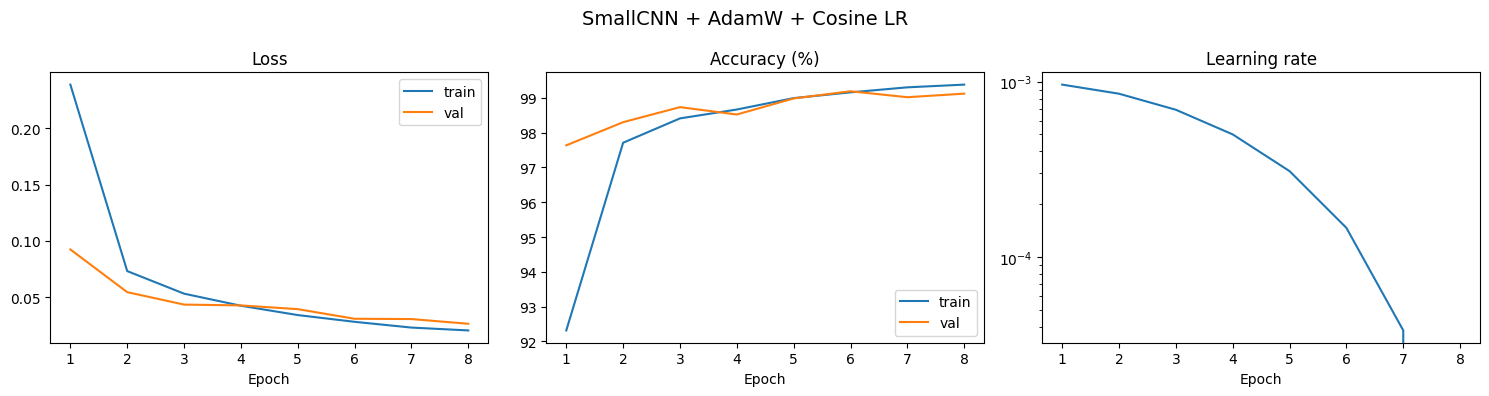

In [15]:
run_cfg = Config(**asdict(cfg))
run_cfg.epochs = 8
run_cfg.lr = 1e-3
run_cfg.weight_decay = 1e-4
run_cfg.dropout = 0.1
run_cfg.use_amp = False  # set True on CUDA if you want AMP

model = SmallCNN(channels=32, dropout=run_cfg.dropout).to(device)
history = fit(model, train_loader, val_loader, run_cfg, optimizer_name="adamw", scheduler_name="cosine")
plot_history(history, title="SmallCNN + AdamW + Cosine LR")


## Test set evaluation

We compute:
- **test accuracy**
- **confusion matrix**
- some **misclassified examples** for qualitative error analysis


In [16]:
@torch.no_grad()
def predict_all(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    preds, targets = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        preds.append(logits.argmax(dim=1).cpu())
        targets.append(yb.cpu())
    return torch.cat(preds), torch.cat(targets)

test_preds, test_targets = predict_all(model, test_loader, device)
test_acc = (test_preds == test_targets).float().mean().item() * 100
print(f"Test accuracy: {test_acc:.2f}%")


Test accuracy: 99.59%


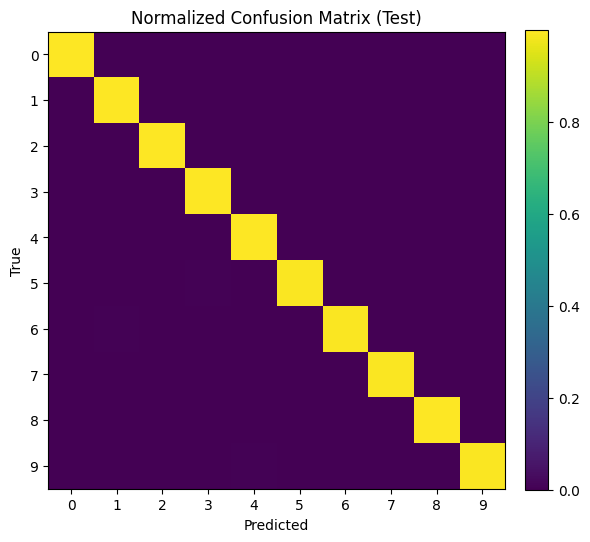

In [17]:
# Confusion matrix
if _HAS_SKLEARN:
    cm = confusion_matrix(test_targets.numpy(), test_preds.numpy(), labels=list(range(10)))
else:
    cm = torch.zeros((10, 10), dtype=torch.int64)
    for t, p in zip(test_targets, test_preds):
        cm[t, p] += 1
    cm = cm.numpy()

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm / cm.sum(axis=1, keepdims=True))
ax.set_title("Normalized Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


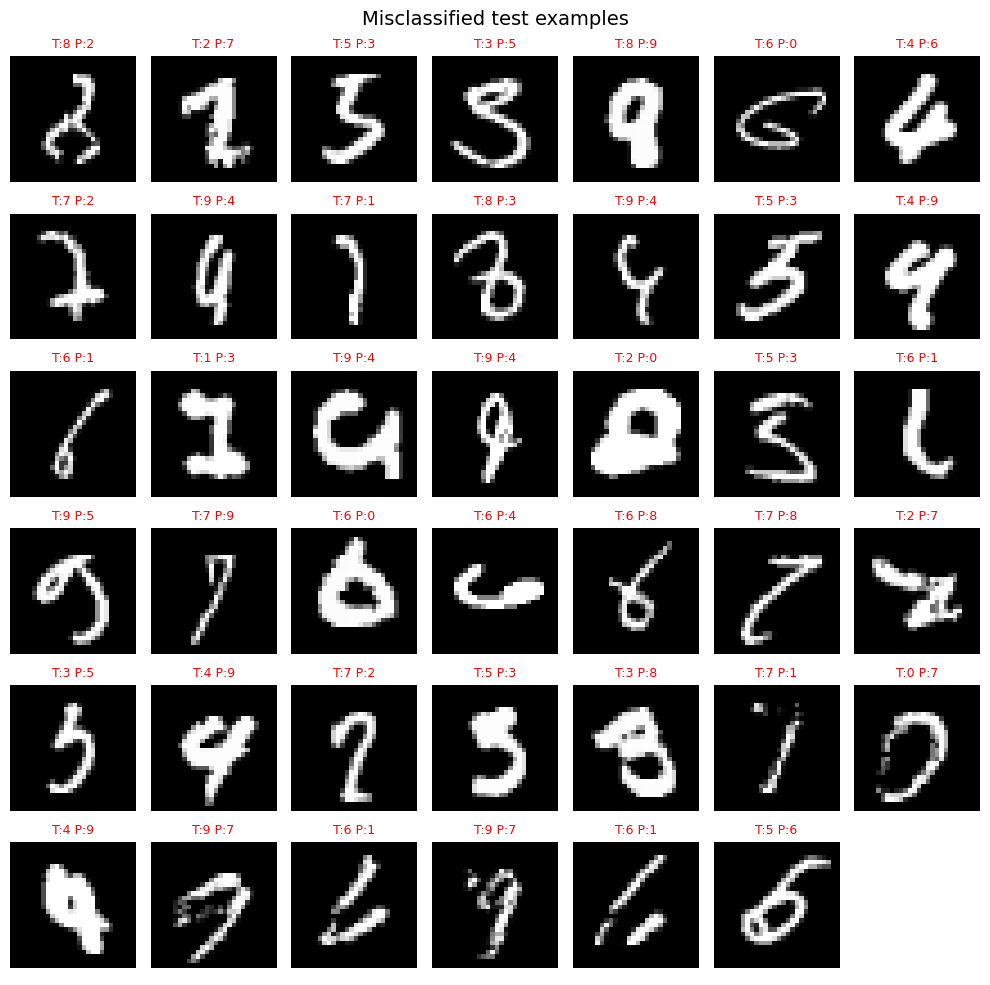

In [18]:
@torch.no_grad()
def show_mistakes(model: nn.Module, loader: DataLoader, device: torch.device, n: int = 36) -> None:
    model.eval()
    mistakes_x, mistakes_y, mistakes_p = [], [], []

    for xb, yb in loader:
        xb_dev = xb.to(device)
        logits = model(xb_dev)
        preds = logits.argmax(dim=1).cpu()
        wrong = preds != yb
        if wrong.any():
            mistakes_x.append(xb[wrong])
            mistakes_y.append(yb[wrong])
            mistakes_p.append(preds[wrong])
        if sum(t.shape[0] for t in mistakes_x) >= n:
            break

    if not mistakes_x:
        print("No mistakes found.")
        return

    x = torch.cat(mistakes_x)[:n]
    y = torch.cat(mistakes_y)[:n]
    p = torch.cat(mistakes_p)[:n]

    x_plot = unnormalize(x).clamp(0, 1)

    rows = int(math.sqrt(n))
    cols = int(math.ceil(n / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i >= n:
            ax.axis("off")
            continue
        ax.imshow(x_plot[i].squeeze(0), cmap="gray")
        ax.set_title(f"T:{y[i].item()} P:{p[i].item()}", fontsize=9, color="red")
        ax.axis("off")
    fig.suptitle("Misclassified test examples", fontsize=14)
    plt.tight_layout()
    plt.show()

show_mistakes(model, test_loader, device, n=41)


## Experiments

This section runs multiple configurations and compares validation accuracy.

You can expand this list to:
- test different channel sizes (CNN width)
- test different dropout / weight decay strengths
- compare augmentation on/off


In [ ]:
def build_model(name: str, cfg: Config) -> nn.Module:
    name = name.lower()
    if name == "mlp":
        return MLP(hidden=256, dropout=cfg.dropout)
    if name == "cnn":
        return SmallCNN(channels=32, dropout=cfg.dropout)
    raise ValueError("Unknown model name. Use 'mlp' or 'cnn'.")

def run_experiment(model_name: str, optimizer_name: str, scheduler_name: Optional[str], cfg: Config, seed: int = 42):
    seed_everything(seed)
    model = build_model(model_name, cfg).to(device)
    print("\n" + "="*80)
    print(f"Model={model_name} | Optimizer={optimizer_name} | Scheduler={scheduler_name} | cfg={cfg}")
    hist = fit(model, train_loader, val_loader, cfg, optimizer_name=optimizer_name, scheduler_name=scheduler_name)
    return hist

exp_cfg = Config(**asdict(cfg))
exp_cfg.epochs = 6
exp_cfg.lr = 1e-3
exp_cfg.dropout = 0.1
exp_cfg.weight_decay = 1e-4

experiments = [
    ("mlp", "adam",  None),
    ("mlp", "sgd",   "step"),
    ("cnn", "adamw", "cosine"),
    ("cnn", "rmsprop", None),
]

all_histories = {}
for m, o, s in experiments:
    key = f"{m.upper()} | {o.upper()} | {s or 'none'}"
    all_histories[key] = run_experiment(m, o, s, exp_cfg, seed=42)

plt.figure(figsize=(10, 4))
for name, hist in all_histories.items():
    plt.plot([a*100 for a in hist["val_acc"]], label=name)
plt.title("Validation accuracy comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()



Model=mlp | Optimizer=adam | Scheduler=None | cfg=Config(data_root='data', batch_size=128, num_workers=2, pin_memory=True, lr=0.001, epochs=6, weight_decay=0.0001, dropout=0.1, use_amp=False, val_fraction=0.1)


  0%|          | 0/422 [00:00<?, ?it/s]

### Optional: Interactive widget

If you run this notebook in a widget-enabled environment (JupyterLab/Colab), this adds a small UI for experiments.


In [ ]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    model_dd = widgets.Dropdown(options=["cnn", "mlp"], value="cnn", description="Model:")
    opt_dd   = widgets.Dropdown(options=["adamw", "adam", "sgd", "rmsprop"], value="adamw", description="Optimizer:")
    sch_dd   = widgets.Dropdown(options=["none", "cosine", "step", "plateau"], value="cosine", description="Scheduler:")

    lr_sl = widgets.FloatLogSlider(value=1e-3, base=10, min=-4, max=-2, step=0.1, description="LR:")
    ep_sl = widgets.IntSlider(value=6, min=1, max=20, step=1, description="Epochs:")
    wd_sl = widgets.FloatLogSlider(value=1e-4, base=10, min=-6, max=-2, step=0.2, description="Weight decay:")
    do_sl = widgets.FloatSlider(value=0.1, min=0.0, max=0.6, step=0.05, description="Dropout:")

    btn = widgets.Button(description="Run", button_style="primary")
    out = widgets.Output()

    def _run(_):
        with out:
            clear_output(wait=True)
            local_cfg = Config(**asdict(cfg))
            local_cfg.lr = float(lr_sl.value)
            local_cfg.epochs = int(ep_sl.value)
            local_cfg.weight_decay = float(wd_sl.value)
            local_cfg.dropout = float(do_sl.value)

            scheduler = None if sch_dd.value == "none" else sch_dd.value
            hist = run_experiment(model_dd.value, opt_dd.value, scheduler, local_cfg, seed=42)
            plot_history(hist, title=f"{model_dd.value.upper()} + {opt_dd.value.upper()} + {scheduler or 'none'}")

    btn.on_click(_run)
    display(widgets.VBox([
        widgets.HBox([model_dd, opt_dd, sch_dd]),
        widgets.HBox([lr_sl, ep_sl]),
        widgets.HBox([wd_sl, do_sl]),
        btn,
        out
    ]))
except Exception as e:
    print("Widgets not available:", repr(e))


### Conclusion
In this notebook, we implemented a PyTorch pipeline for digit classification on the MNIST dataset, comparing a simple fully connected neural network (MLP) with a small convolutional neural network (CNN). The workflow covered data preprocessing, model definition, training, evaluation, and basic experiment management.

While the MLP baseline is able to achieve reasonably strong performance by treating each image as a flattened vector, the CNN consistently outperforms it by explicitly exploiting local spatial structure through convolutional layers and pooling. This leads to faster convergence, better generalization, and higher test accuracy, even with a relatively shallow architecture.

## References

Optimization & deep learning foundations  
- *Deep Learning* (Goodfellow, Bengio, Courville): https://www.deeplearningbook.org/  
- Adam (Kingma & Ba, 2014): https://arxiv.org/abs/1412.6980  
- AdamW (Loshchilov & Hutter, 2017): https://arxiv.org/abs/1711.05101  
- BatchNorm (Ioffe & Szegedy, 2015): https://arxiv.org/abs/1502.03167  
- Dropout (Srivastava et al., 2014): https://jmlr.org/papers/v15/srivastava14a.html  

Intuition and explanations  
- 3Blue1Brown neural networks series: https://www.3blue1brown.com/topics/neural-networks  
- Michael Nielsen, *Neural Networks and Deep Learning*: http://neuralnetworksanddeeplearning.com/  

MNIST dataset  
- LeCun et al. MNIST page: http://yann.lecun.com/exdb/mnist/  
- Kaggle: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
- GTDLBench: https://git-disl.github.io/GTDLBench/datasets/mnist_datasets/
- TensorFlow: https://www.tensorflow.org/datasets/catalog/mnist
- Hugging Face: https://huggingface.co/datasets/ylecun/mnist